In [1]:
import os
import logging
from pathlib import Path
import datetime

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim
from torchinfo import summary

import torchmetrics

import cv2

import config
import datasets
import dataset_dfire
import models
import loss
import metrics
import train_epoch
import val_epoch
import utils

from neural_compressor import QuantizationAwareTrainingConfig
from neural_compressor.training import prepare_compression

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.11 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = config.LOGS_FOLDER

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny.\n' +  
            '\tOne Head.\n' +
            '\t255 Normalization.\n' +
            '\tWeighted for Precision.\n' +
            '\tModules.\n'+ 
            '\tLosses and Metrics Loggers.\n' +
            '\tMore checkpoints.\n' +
            '\tQAT with Neural Compressor.\n' +
            '\tNo Tuning.\n' +
            '\tFASDD Dataset included.\n' +
            f'\tEpochs = {config.EPOCHS}')

# View Dataset

### Transform

In [4]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [5]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = dataset_dfire.DFireDataset(
    img_h=config.IMG_H, 
    img_w=config.IMG_W, 
    img_dir=config.val_imgs, 
    label_dir=config.val_labels, 
    num_classes=config.N_CLASSES,
    ds_len=2*VIEW_BATCH_SIZE,
    transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

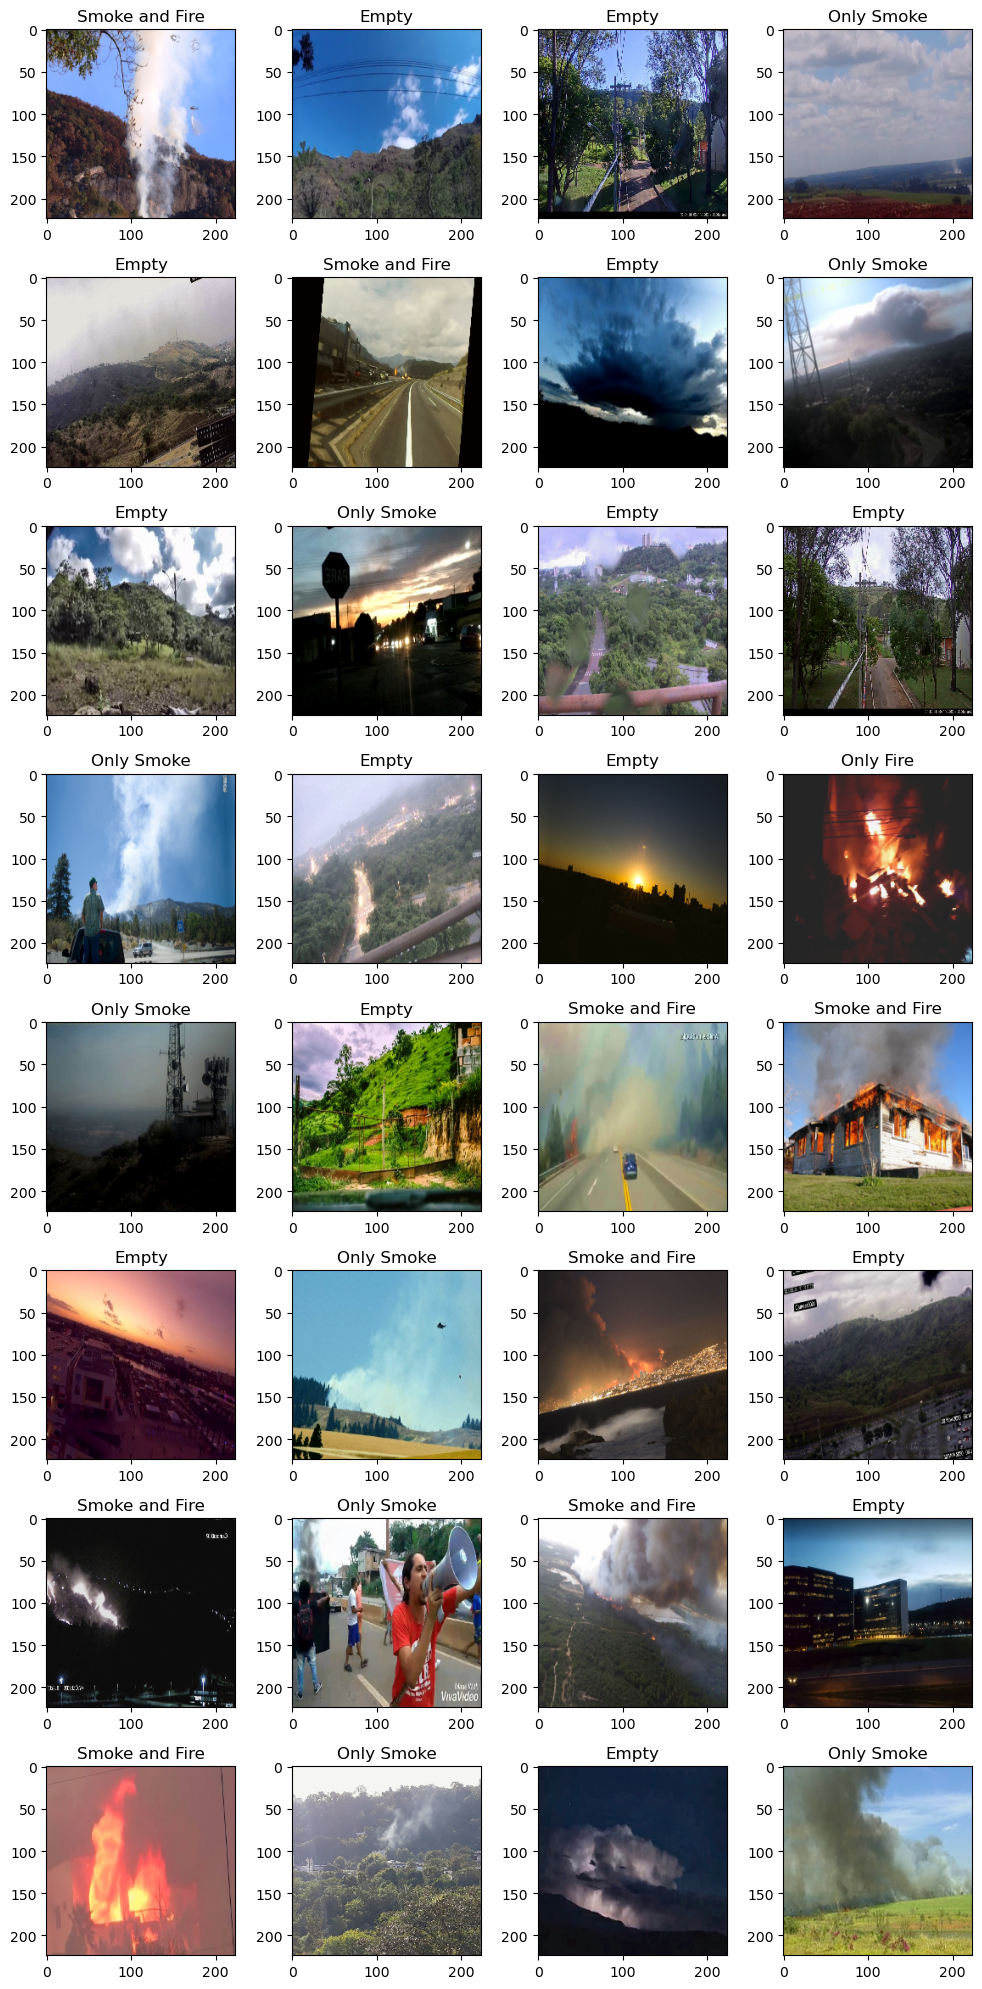

In [6]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Dataset Setup

In [7]:
train_loader = datasets.get_train_loader()
val_loader = datasets.get_val_loader()


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763

Train DFire dataset len: 17221

TRAIN FASDD UAV dataset
DFire Removed wrong images: 0
DFire empty images: 5994
DFire only smoke images: 2541
DFire only fire images: 105
DFire smoke and fire images: 3911

Train FASDD UAV dataset len: 12551

TRAIN FASDD CV dataset


DFire Removed wrong images: 0
DFire empty images: 19600
DFire only smoke images: 11708
DFire only fire images: 6276
DFire smoke and fire images: 10076

Train FASDD CV dataset len: 47660

Concatenate Train DFire and FASDD UAV datasets
Train dataset len: 29772
Concatenate with FASDD CV dataset
Train dataset len: 77432

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895

Test dataset len: 4306

TEST FASDD UAV dataset
DFire Removed wrong images: 0
DFire empty images: 1997
DFire only smoke images: 846
DFire only fire images: 35
DFire smoke and fire images: 1303

Test FASDD UAV dataset len: 4181

TEST FASDD CV dataset
DFire Removed wrong images: 0
DFire empty images: 6533
DFire only smoke images: 3902
DFire only fire images: 2091
DFire smoke and fire images: 3358

Test FASDD CV dataset len: 15884
Concatenate Test DFire and FASDD UAV datasets
Test dataset len: 8487
Concatenate wit

# Model Setup

In [8]:
if config.MODEL == "BED":
    print("Using BED Classifier")
    logger.info("\nUsing BED Classifier")
    fp32_model = models.BED_CLASSIFIER(num_classes=config.N_CLASSES).to(config.DEVICE)   
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

optimizer = optim.Adam(fp32_model.parameters(), 
                       lr=config.LEARNING_RATE, 
                       weight_decay=config.WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=config.FACTOR, 
                                                 patience=config.PATIENCE, 
                                                 threshold=config.THRES, 
                                                 threshold_mode='abs',
                                                 min_lr=config.MIN_LR)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in fp32_model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(fp32_model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier

Trainable parameters = 93266
Total parameters = 93266



### Check Model Shape

In [9]:
in_rand_np = np.random.rand(4, 3, config.IMG_H, config.IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=config.DEVICE)
out_test = fp32_model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{fp32_model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{fp32_model}')

Model shape is tensor([[-0.3334, -0.1113],
        [-0.4391, -0.1174],
        [-0.3571, -0.0456],
        [-0.4432, -0.1571]], device='cuda:0', grad_fn=<AddmmBackward0>)
BED Model Arquitecture
BED_CLASSIFIER(
  (model): Sequential(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (dropout1): Dropout2d(p=0.3, inplace=False)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (dropout2): Dropout2d(p=0.3, inplace=False)
    (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv31): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn31)

# Torchinfo: model summary

### FP32 Model

In [10]:
print(summary(fp32_model, input_size=(1, 3, config.IMG_H, config.IMG_W)))
logger.info(summary(fp32_model, input_size=(1, 3, config.IMG_H, config.IMG_W)))

Layer (type:depth-idx)                   Output Shape              Param #
BED_CLASSIFIER                           [1, 2]                    --
├─Sequential: 1-1                        [1, 2]                    --
│    └─Conv2d: 2-1                       [1, 32, 224, 224]         864
│    └─BatchNorm2d: 2-2                  [1, 32, 224, 224]         64
│    └─ReLU: 2-3                         [1, 32, 224, 224]         --
│    └─Dropout2d: 2-4                    [1, 32, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 32, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 16, 112, 112]         4,608
│    └─BatchNorm2d: 2-7                  [1, 16, 112, 112]         32
│    └─ReLU: 2-8                         [1, 16, 112, 112]         --
│    └─Dropout2d: 2-9                    [1, 16, 112, 112]         --
│    └─MaxPool2d: 2-10                   [1, 16, 56, 56]           --
│    └─Conv2d: 2-11                      [1, 16, 56, 56]           256
│    └─Bat

# Load Model

Optimizer and Scheduler passed as None to load_checkpoint, so model start training with hyperparameters defined in config and not with hyperparameters of the model loaded.

In [11]:
model_path = 'BED_classifier__best_smoke__precision=0.935__epoch=87.pt'
epoch_saved = utils.load_checkpoint(model_path, fp32_model, None, None, config.DEVICE)

Loading Model. Trained during 87 epochs


# Loss Function

In [12]:
if config.LOSS_FN == "BCE":
    print(f'Loss Function: BCE')
    logger.info(f'\nLoss Function: BCE')
    print(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    logger.info(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    loss_fn = loss.BCE_LOSS(device=config.DEVICE, smoke_precision_weight=config.SMOKE_PRECISION_WEIGHT)
else:
    print("Wrong loss function")
    logger.info("Wrong loss function")
    raise SystemExit("Wrong loss function")

Loss Function: BCE
Smoke Precision Weight: 0.8


# Print and Log Config Values

In [13]:
''' ============================
    Print Config Values
============================ '''
print(f'\nDevice: {config.DEVICE}')
print(f'Learning Rate: {config.LEARNING_RATE}')
print(f'Weight Decay: {config.WEIGHT_DECAY}')
print(f'Batch Size: {config.BATCH_SIZE}')
print(f'IMG DIMS: ({config.IMG_H}, {config.IMG_W})')

logger.info(f'\nDevice: {config.DEVICE}')
logger.info(f'Learning Rate: {config.LEARNING_RATE}')
logger.info(f'Optimizer Weight Decay: {config.WEIGHT_DECAY}')
logger.info(f'Scheduler factor: {config.FACTOR}')
logger.info(f'Scheduler patience: {config.PATIENCE}')
logger.info(f'Scheduler threshold: {config.THRES}')
logger.info(f'Scheduler min learning rate: {config.MIN_LR}')
logger.info(f'Batch Size: {config.BATCH_SIZE}')
logger.info(f'W: {config.IMG_W}\nH: {config.IMG_H}')


Device: cuda
Learning Rate: 0.0001
Weight Decay: 0.0001
Batch Size: 64
IMG DIMS: (224, 224)


# Loss and Metrics Loggers and Plotters

In [14]:
train_losses_logger = utils.LogLosses()
train_metrics_logger = utils.LogMetrics()
lr_logger = utils.LogLR(log_path=config.PLOTS_FOLDER)

val_losses_logger = utils.LogLosses()
val_metrics_logger = utils.LogMetrics()

loss_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Loss')
metrics_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Metric')

# Main Function

In [15]:
def train_loop(model, start_epoch=0):

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')
    
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = 0. #torch.tensor([0.])
    smoke_f1_min_save = 0.9 #torch.tensor([0.9])
    best_mean_f1 = 0.

    #start_epoch = 0
    epochs_plot = []
        
    for epoch in range(start_epoch, config.EPOCHS):

        print(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        
        #====================== TRAINING ========================#
        current_lr = train_epoch.get_lr(optimizer=optimizer)
        logger.info(f'Learning Rate = {current_lr:.6f}\n')
        lr_logger.log_lr(current_lr)
                
        train_losses, train_metrics = train_epoch.train_fn(
            loader=train_loader, 
            model=model, 
            optimizer=optimizer, 
            loss_fn=loss_fn,
            device=config.DEVICE)
        
        train_losses_logger.update_metrics(train_losses)
        train_metrics_logger.update_metrics(train_metrics)
                
        logger.info(utils.print_metrics_to_logger("TRAIN Stats", train_losses, train_metrics))
        
        #===================== VALIDATING =======================#
        with torch.no_grad():
            val_losses, val_metrics = val_epoch.eval_fn(
                loader=val_loader, 
                model=model,                         
                loss_fn=loss_fn,
                device=config.DEVICE)
            
            scheduler.step(val_losses['Total'])
            
            val_losses_logger.update_metrics(val_losses)
            val_metrics_logger.update_metrics(val_metrics)

            logger.info(utils.print_metrics_to_logger("VAL Stats", val_losses, val_metrics))
            
        epochs_plot.append(epoch)

        loss_plotter.plot_all_metrics(
            train_losses_logger.get_metrics(),
            val_losses_logger.get_metrics(),
            epochs_plot)

        metrics_plotter.plot_all_metrics(
            train_metrics_logger.get_metrics(),
            val_metrics_logger.get_metrics(),
            epochs_plot)

        lr_logger.plot_lr(epochs_plot)
        
        #======================= SAVING =========================#
        if ( (epoch+1) % 5 ) == 0:
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__5epoch.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 
            
        if best_valid_loss > val_losses['Total']:
            best_valid_loss = val_losses['Total']
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"Saving model with new best validation loss: {best_valid_loss:.3f}")
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + 'best_loss'  + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  

        # Save model if precision increases and F1 > 0.9
        if ( best_smoke_precision < val_metrics['Precision'][0] ) and ( val_metrics['F1'][0] > smoke_f1_min_save ) :
            best_smoke_precision = val_metrics['Precision'][0]
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"Saving model with new best smoke precision: {best_smoke_precision:.3f}")
            save_precision_name = f'best_smoke__precision={np.round(best_smoke_precision, decimals=4)}__epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_precision_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  
            
        # Save model if precision > 0.9 and recall > 0.9
        if ( val_metrics['Precision'][0] > 0.9 ) and ( val_metrics['Recall'][0] > 0.9 ) :
            print("\nSaving model with precision > 0.9 and recall > 0.9")
            logger.info("Saving model with precision > 0.9 and recall > 0.9")
            save_pre_name = f'smoke__precision={np.round(val_metrics["Precision"][0], decimals=4)}__' 
            save_rec_name = f'recall={np.round(val_metrics["Recall"][0], decimals=4)}__'
            save_pre_rec_name = save_pre_name + save_rec_name + f'epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_pre_rec_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  
            
        # Save model if best mean F1 increases
        val_f1_mean = (val_metrics['F1'][0] + val_metrics['F1'][1]) / 2
        if (val_f1_mean > best_mean_f1) :
            best_mean_f1 = val_f1_mean
            print(f'Saving model with best Mean F1: {best_mean_f1:.4f}')
            logger.info(f'Saving model with best Mean F1: {best_mean_f1:.4f}')
            save_f1_name = 'best_mean_F1'
            save_name = config_aimet.WEIGHTS_FOLDER + config_aimet.MODEL + '_classifier__' + save_f1_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)
            
        # End training if results are good enough
        if ( ( val_metrics['Precision'][0] > 0.93 ) and ( val_metrics['Recall'][0] > 0.88 ) and
            ( val_metrics['Precision'][1] > 0.9  ) ):
            break
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), config.WEIGHTS_FOLDER + 'last_' + config.MODEL + '_classifier.pt') 
    
    #======================= FINISH =========================#
    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [16]:
if __name__ == "__main__":
       
    # set CPU
    fp32_model.to('cpu')
    conf = QuantizationAwareTrainingConfig()
    compression_manager = prepare_compression(fp32_model, conf)
    compression_manager.callbacks.on_train_begin()
    model = compression_manager.model
    
    # set GPU
    model.to(config.DEVICE)
    quant_model = train_loop(model)
    
    # set CPU
    model.to('cpu')
    quant_model.to('cpu')
    compression_manager.callbacks.on_train_end()
    compression_manager.save(config.RUN_FOLDER + "output")

/opt/conda/envs/pytorch_23/lib/python3.10/site-packages/torch/ao/quantization/fx/fuse.py:56: UserWarning: Passing a fuse_custom_config_dict to fuse is deprecated and will not be supported in a future version. Please pass in a FuseCustomConfig instead.
  warnings.warn(
2024-07-12 20:13:58 [INFO] Attention Blocks: 0
2024-07-12 20:13:58 [INFO] FFN Blocks: 0
/opt/conda/envs/pytorch_23/lib/python3.10/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(



***Start Training: 20:13:58


=== EPOCH 0/39 ===
Learning Rate = 0.0001



Training:   0%|                                                                                           | 0/1209 [00:00<?, ?it/s]/opt/conda/envs/pytorch_23/lib/python3.10/site-packages/torch/ao/quantization/fake_quantize.py:353: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905979055/work/aten/src/ATen/native/ReduceAllOps.cpp:71.)
  return torch.fused_moving_avg_obs_fake_quant(
/opt/conda/envs/pytorch_23/lib/python3.10/site-packages/torch/ao/quantization/fake_quantize.py:353: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905979055/work/aten/src/ATen/native/TensorCompare.cpp:687.)
  return torch.fused_moving_avg_obs_fake_quant(
Training:

Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.419      |11.543      |6.876       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.380      |13.625      |6.755       
SMOKE -> Precision: 0.927 - Recall: 0.866 - Accuracy: 0.905 - F1: 0.895
FIRE -> Precision: 0.916 - Recall: 0.972 - Accuracy: 0.962 - F1: 0.943

Saving model with new best validation loss: 20.380

=== EPOCH 1/39 ===
Learning Rate = 0.0001



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:21<00:00,  6.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.160      |11.397      |6.763       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.019      |13.678      |7.341       
SMOKE -> Precision: 0.931 - Recall: 0.853 - Accuracy: 0.901 - F1: 0.890
FIRE -> Precision: 0.911 - Recall: 0.968 - Accuracy: 0.959 - F1: 0.938

=== EPOCH 2/39 ===
Learning Rate = 0.0001



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:18<00:00,  6.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.118      |11.454      |6.663       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.381      |13.070      |7.310       
SMOKE -> Precision: 0.924 - Recall: 0.871 - Accuracy: 0.906 - F1: 0.897
FIRE -> Precision: 0.907 - Recall: 0.972 - Accuracy: 0.959 - F1: 0.938

=== EPOCH 3/39 ===
Learning Rate = 0.0001



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:23<00:00,  5.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.116      |11.479      |6.637       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.053      |13.587      |7.466       
SMOKE -> Precision: 0.937 - Recall: 0.845 - Accuracy: 0.900 - F1: 0.889
FIRE -> Precision: 0.901 - Recall: 0.974 - Accuracy: 0.957 - F1: 0.936

=== EPOCH 4/39 ===
Learning Rate = 8e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:22<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.812      |11.241      |6.570       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.207      |13.290      |6.917       
SMOKE -> Precision: 0.928 - Recall: 0.863 - Accuracy: 0.904 - F1: 0.894
FIRE -> Precision: 0.918 - Recall: 0.970 - Accuracy: 0.962 - F1: 0.943

Saving model with new best validation loss: 20.207

=== EPOCH 5/39 ===
Learning Rate = 8e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:23<00:00,  5.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.817      |11.217      |6.600       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.772      |14.213      |7.559       
SMOKE -> Precision: 0.913 - Recall: 0.869 - Accuracy: 0.899 - F1: 0.890
FIRE -> Precision: 0.908 - Recall: 0.969 - Accuracy: 0.958 - F1: 0.937

=== EPOCH 6/39 ===
Learning Rate = 8e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:23<00:00,  5.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.923      |11.285      |6.638       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.605      |14.241      |7.365       
SMOKE -> Precision: 0.927 - Recall: 0.841 - Accuracy: 0.894 - F1: 0.882
FIRE -> Precision: 0.910 - Recall: 0.971 - Accuracy: 0.960 - F1: 0.940

=== EPOCH 7/39 ===
Learning Rate = 8e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:20<00:00,  6.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.921      |11.245      |6.677       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.187      |14.715      |7.471       
SMOKE -> Precision: 0.907 - Recall: 0.862 - Accuracy: 0.894 - F1: 0.884
FIRE -> Precision: 0.907 - Recall: 0.970 - Accuracy: 0.958 - F1: 0.938

=== EPOCH 8/39 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:21<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.531      |11.055      |6.476       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.603      |13.321      |7.282       
SMOKE -> Precision: 0.933 - Recall: 0.862 - Accuracy: 0.905 - F1: 0.896
FIRE -> Precision: 0.914 - Recall: 0.967 - Accuracy: 0.960 - F1: 0.940

=== EPOCH 9/39 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:21<00:00,  6.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.441      |11.024      |6.417       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.183      |13.735      |7.448       
SMOKE -> Precision: 0.921 - Recall: 0.860 - Accuracy: 0.899 - F1: 0.890
FIRE -> Precision: 0.910 - Recall: 0.970 - Accuracy: 0.959 - F1: 0.939

=== EPOCH 10/39 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:19<00:00,  6.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.537      |11.096      |6.441       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.625      |13.681      |6.945       
SMOKE -> Precision: 0.919 - Recall: 0.876 - Accuracy: 0.905 - F1: 0.897
FIRE -> Precision: 0.916 - Recall: 0.971 - Accuracy: 0.962 - F1: 0.943

=== EPOCH 11/39 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:21<00:00,  6.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.353      |10.917      |6.436       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.962      |13.888      |7.074       
SMOKE -> Precision: 0.917 - Recall: 0.868 - Accuracy: 0.900 - F1: 0.892
FIRE -> Precision: 0.914 - Recall: 0.969 - Accuracy: 0.960 - F1: 0.940

=== EPOCH 12/39 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:21<00:00,  6.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.454      |10.886      |6.567       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.207      |13.126      |7.081       
SMOKE -> Precision: 0.940 - Recall: 0.850 - Accuracy: 0.903 - F1: 0.892
FIRE -> Precision: 0.913 - Recall: 0.973 - Accuracy: 0.961 - F1: 0.942

Saving model with new best validation loss: 20.207

=== EPOCH 13/39 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:22<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.320      |10.849      |6.471       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.304      |13.269      |7.034       
SMOKE -> Precision: 0.931 - Recall: 0.854 - Accuracy: 0.901 - F1: 0.891
FIRE -> Precision: 0.915 - Recall: 0.973 - Accuracy: 0.962 - F1: 0.943

=== EPOCH 14/39 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:21<00:00,  6.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.091      |10.793      |6.298       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.388      |13.737      |7.651       
SMOKE -> Precision: 0.928 - Recall: 0.856 - Accuracy: 0.901 - F1: 0.891
FIRE -> Precision: 0.906 - Recall: 0.971 - Accuracy: 0.958 - F1: 0.937

=== EPOCH 15/39 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:23<00:00,  5.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.141      |10.874      |6.267       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.536      |13.601      |7.935       
SMOKE -> Precision: 0.938 - Recall: 0.844 - Accuracy: 0.900 - F1: 0.888
FIRE -> Precision: 0.900 - Recall: 0.975 - Accuracy: 0.957 - F1: 0.936

=== EPOCH 16/39 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:21<00:00,  6.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.275      |10.879      |6.396       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.419      |14.004      |7.415       
SMOKE -> Precision: 0.913 - Recall: 0.869 - Accuracy: 0.899 - F1: 0.890
FIRE -> Precision: 0.905 - Recall: 0.973 - Accuracy: 0.958 - F1: 0.938

=== EPOCH 17/39 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:21<00:00,  6.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.030      |10.684      |6.346       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.520      |13.680      |7.840       
SMOKE -> Precision: 0.934 - Recall: 0.857 - Accuracy: 0.904 - F1: 0.894
FIRE -> Precision: 0.907 - Recall: 0.971 - Accuracy: 0.958 - F1: 0.938

=== EPOCH 18/39 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:22<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.089      |10.718      |6.371       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.955      |13.640      |7.315       
SMOKE -> Precision: 0.927 - Recall: 0.859 - Accuracy: 0.902 - F1: 0.892
FIRE -> Precision: 0.909 - Recall: 0.973 - Accuracy: 0.959 - F1: 0.940

=== EPOCH 19/39 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:21<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.175      |10.757      |6.418       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.406      |13.532      |6.874       
SMOKE -> Precision: 0.933 - Recall: 0.857 - Accuracy: 0.904 - F1: 0.893
FIRE -> Precision: 0.919 - Recall: 0.970 - Accuracy: 0.962 - F1: 0.944

=== EPOCH 20/39 ===
Learning Rate = 2.6214400000000015e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:20<00:00,  6.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.952      |10.601      |6.351       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.600      |13.654      |7.946       
SMOKE -> Precision: 0.927 - Recall: 0.859 - Accuracy: 0.902 - F1: 0.892
FIRE -> Precision: 0.899 - Recall: 0.973 - Accuracy: 0.956 - F1: 0.935

=== EPOCH 21/39 ===
Learning Rate = 2.6214400000000015e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:20<00:00,  6.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.111      |10.763      |6.347       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.901      |13.644      |7.257       
SMOKE -> Precision: 0.931 - Recall: 0.856 - Accuracy: 0.902 - F1: 0.892
FIRE -> Precision: 0.909 - Recall: 0.973 - Accuracy: 0.960 - F1: 0.940

=== EPOCH 22/39 ===
Learning Rate = 2.6214400000000015e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:22<00:00,  5.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.033      |10.659      |6.373       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.933      |13.492      |7.441       
SMOKE -> Precision: 0.930 - Recall: 0.863 - Accuracy: 0.905 - F1: 0.895
FIRE -> Precision: 0.909 - Recall: 0.969 - Accuracy: 0.959 - F1: 0.938

=== EPOCH 23/39 ===
Learning Rate = 2.0971520000000012e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:22<00:00,  5.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.912      |10.599      |6.314       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.089      |13.256      |6.834       
SMOKE -> Precision: 0.940 - Recall: 0.857 - Accuracy: 0.907 - F1: 0.897
FIRE -> Precision: 0.921 - Recall: 0.968 - Accuracy: 0.962 - F1: 0.944

Saving model with new best validation loss: 20.089

=== EPOCH 24/39 ===
Learning Rate = 2.0971520000000012e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:18<00:00,  6.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.600      |10.460      |6.140       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.760      |13.803      |7.957       
SMOKE -> Precision: 0.922 - Recall: 0.862 - Accuracy: 0.901 - F1: 0.891
FIRE -> Precision: 0.899 - Recall: 0.976 - Accuracy: 0.957 - F1: 0.936

=== EPOCH 25/39 ===
Learning Rate = 2.0971520000000012e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:22<00:00,  5.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.917      |10.658      |6.259       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.277      |13.605      |6.671       
SMOKE -> Precision: 0.931 - Recall: 0.856 - Accuracy: 0.902 - F1: 0.892
FIRE -> Precision: 0.919 - Recall: 0.970 - Accuracy: 0.962 - F1: 0.943

=== EPOCH 26/39 ===
Learning Rate = 2.0971520000000012e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:23<00:00,  5.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.827      |10.570      |6.257       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.449      |13.476      |6.972       
SMOKE -> Precision: 0.930 - Recall: 0.865 - Accuracy: 0.905 - F1: 0.896
FIRE -> Precision: 0.919 - Recall: 0.970 - Accuracy: 0.962 - F1: 0.943

=== EPOCH 27/39 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:20<00:00,  6.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.666      |10.492      |6.174       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.502      |13.300      |7.202       
SMOKE -> Precision: 0.930 - Recall: 0.865 - Accuracy: 0.906 - F1: 0.896
FIRE -> Precision: 0.912 - Recall: 0.975 - Accuracy: 0.961 - F1: 0.942

=== EPOCH 28/39 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:23<00:00,  5.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.464      |10.314      |6.150       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.480      |13.295      |7.185       
SMOKE -> Precision: 0.933 - Recall: 0.859 - Accuracy: 0.904 - F1: 0.894
FIRE -> Precision: 0.916 - Recall: 0.971 - Accuracy: 0.962 - F1: 0.943

=== EPOCH 29/39 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:20<00:00,  6.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.759      |10.573      |6.186       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.626      |13.198      |7.428       
SMOKE -> Precision: 0.929 - Recall: 0.864 - Accuracy: 0.905 - F1: 0.896
FIRE -> Precision: 0.907 - Recall: 0.974 - Accuracy: 0.959 - F1: 0.939

=== EPOCH 30/39 ===
Learning Rate = 1.3421772800000009e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:21<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.641      |10.422      |6.220       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.490      |13.325      |7.165       
SMOKE -> Precision: 0.934 - Recall: 0.855 - Accuracy: 0.903 - F1: 0.893
FIRE -> Precision: 0.916 - Recall: 0.969 - Accuracy: 0.961 - F1: 0.942

=== EPOCH 31/39 ===
Learning Rate = 1.3421772800000009e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:21<00:00,  5.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.711      |10.473      |6.238       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.010      |13.626      |7.385       
SMOKE -> Precision: 0.932 - Recall: 0.854 - Accuracy: 0.902 - F1: 0.891
FIRE -> Precision: 0.912 - Recall: 0.971 - Accuracy: 0.960 - F1: 0.940

=== EPOCH 32/39 ===
Learning Rate = 1.3421772800000009e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:22<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.968      |10.579      |6.389       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.560      |13.787      |7.773       
SMOKE -> Precision: 0.926 - Recall: 0.856 - Accuracy: 0.900 - F1: 0.890
FIRE -> Precision: 0.903 - Recall: 0.975 - Accuracy: 0.958 - F1: 0.938

=== EPOCH 33/39 ===
Learning Rate = 1.0737418240000008e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:21<00:00,  6.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.742      |10.551      |6.191       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.181      |13.334      |6.847       
SMOKE -> Precision: 0.930 - Recall: 0.864 - Accuracy: 0.905 - F1: 0.896
FIRE -> Precision: 0.921 - Recall: 0.969 - Accuracy: 0.963 - F1: 0.944

=== EPOCH 34/39 ===
Learning Rate = 1.0737418240000008e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:21<00:00,  6.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.512      |10.423      |6.088       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.768      |13.707      |7.061       
SMOKE -> Precision: 0.921 - Recall: 0.870 - Accuracy: 0.904 - F1: 0.895
FIRE -> Precision: 0.916 - Recall: 0.970 - Accuracy: 0.961 - F1: 0.942

=== EPOCH 35/39 ===
Learning Rate = 1.0737418240000008e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:21<00:00,  6.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.676      |10.479      |6.197       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.014      |13.713      |7.301       
SMOKE -> Precision: 0.931 - Recall: 0.858 - Accuracy: 0.903 - F1: 0.893
FIRE -> Precision: 0.907 - Recall: 0.974 - Accuracy: 0.959 - F1: 0.939

=== EPOCH 36/39 ===
Learning Rate = 8.589934592000007e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:19<00:00,  6.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.619      |10.498      |6.122       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.256      |13.541      |7.715       
SMOKE -> Precision: 0.928 - Recall: 0.862 - Accuracy: 0.903 - F1: 0.894
FIRE -> Precision: 0.907 - Recall: 0.972 - Accuracy: 0.959 - F1: 0.938

=== EPOCH 37/39 ===
Learning Rate = 8.589934592000007e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:20<00:00,  6.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.496      |10.382      |6.114       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.338      |13.616      |7.722       
SMOKE -> Precision: 0.927 - Recall: 0.865 - Accuracy: 0.904 - F1: 0.895
FIRE -> Precision: 0.903 - Recall: 0.976 - Accuracy: 0.958 - F1: 0.938

=== EPOCH 38/39 ===
Learning Rate = 8.589934592000007e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:22<00:00,  5.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.858      |10.570      |6.287       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.363      |13.817      |7.546       
SMOKE -> Precision: 0.927 - Recall: 0.861 - Accuracy: 0.902 - F1: 0.893
FIRE -> Precision: 0.906 - Recall: 0.973 - Accuracy: 0.959 - F1: 0.938

=== EPOCH 39/39 ===
Learning Rate = 6.871947673600007e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:21<00:00,  6.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.549      |10.396      |6.153       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.906      |13.661      |7.245       
SMOKE -> Precision: 0.930 - Recall: 0.861 - Accuracy: 0.904 - F1: 0.894
FIRE -> Precision: 0.909 - Recall: 0.973 - Accuracy: 0.960 - F1: 0.940


2024-07-12 22:44:17 [INFO] |********Mixed Precision Statistics*******|
2024-07-12 22:44:17 [INFO] +------------------------+--------+-------+
2024-07-12 22:44:17 [INFO] |        Op Type         | Total  |  INT8 |
2024-07-12 22:44:17 [INFO] +------------------------+--------+-------+
2024-07-12 22:44:17 [INFO] |  quantize_per_tensor   |   4    |   4   |
2024-07-12 22:44:17 [INFO] |       ConvReLU2d       |   12   |   12  |
2024-07-12 22:44:17 [INFO] |       dequantize       |   4    |   4   |
2024-07-12 22:44:17 [INFO] |       MaxPool2d        |   3    |   3   |
2024-07-12 22:44:17 [INFO] |   AdaptiveAvgPool2d    |   1    |   1   |
2024-07-12 22:44:17 [INFO] |        Dropout         |   1    |   1   |
2024-07-12 22:44:17 [INFO] |       LinearReLU       |   1    |   1   |
2024-07-12 22:44:17 [INFO] |         Linear         |   1    |   1   |
2024-07-12 22:44:17 [INFO] +------------------------+--------+-------+
2024-07-12 22:44:17 [INFO] Training finished!
2024-07-12 22:44:17 [INFO] Save


***Script finished: 22:44:17

Time elapsed: 2:30:18.564248


In [17]:
from neural_compressor.config import Torch2ONNXConfig

int8_onnx_config = Torch2ONNXConfig(
    dtype="int8",
    opset_version=14,
    quant_format="QOperator",  # or QDQ
    example_inputs=torch.randn(1, 3, 224, 224),
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
)
quant_model.export(config.RUN_FOLDER + "int8-model-bnAffine_qat_v1.onnx", int8_onnx_config)
model.export(config.RUN_FOLDER + "int8-model-bnAffine_qat_v2.onnx", int8_onnx_config)

2024-07-12 22:44:17 [INFO] *****************************************************************************************************
2024-07-12 22:44:17 [INFO] The INT8 ONNX Model exported to path: experiments/v10_no_Tuning_fasdd/int8-model-bnAffine_qat_v1.onnx
2024-07-12 22:44:17 [INFO] *****************************************************************************************************
2024-07-12 22:44:17 [INFO] *****************************************************************************************************
2024-07-12 22:44:17 [INFO] The INT8 ONNX Model exported to path: experiments/v10_no_Tuning_fasdd/int8-model-bnAffine_qat_v2.onnx
2024-07-12 22:44:17 [INFO] *****************************************************************************************************


In [18]:
print(quant_model)

PyTorchFXModel(
  (_model): GraphModule(
    (model): Module(
      (conv1): QuantizedConvReLU2d(3, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.05731017142534256, zero_point=0, padding=(1, 1))
      (dropout1): Dropout2d(p=0.3, inplace=False)
      (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2): QuantizedConvReLU2d(32, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.07034908980131149, zero_point=0, padding=(1, 1))
      (dropout2): Dropout2d(p=0.3, inplace=False)
      (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv31): QuantizedConvReLU2d(16, 16, kernel_size=(1, 1), stride=(1, 1), scale=0.04827028885483742, zero_point=0)
      (conv32): QuantizedConvReLU2d(16, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.056962091475725174, zero_point=0, padding=(1, 1))
      (conv33): QuantizedConvReLU2d(32, 32, kernel_size=(1, 1), stride=(1, 1), scale=0.04783859848976135, zero_point=0)
      